In [1]:
import numpy as np
import os
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
# from matplotlib.colors import DivergingNorm
# import matplotlib.patches as patches
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns; sns.set(color_codes=False)
import cmocean
# from windrose import WindroseAxes

import cftime
import datetime
import warnings
import copy


plt.rcParams['xtick.bottom'] = True # keep my tick marks
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = 18
# plt.rcParams['figure.figsize'] = 12,8
# mpl.rcParams['figure.dpi'] = 300 # activate for presentation quality

# from sklearn.metrics.pairwise import haversine_distances

## this is a dummy grid that has the right conventions
grid = xr.open_dataset(
    '/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')

## circle boundary for plotting
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


In [2]:
##### MODEL DATA #####
mdir = '/glade/work/lettier/CICE/cicefsdww3i_output_concat/' ## location of file before changing dim names
mdir_adj = '/glade/u/home/vcooper/work/BGEP_vtc/adjfiles/' # location of adjusted files, changed dims to lat and lon
timeslice1719 = slice('2017-01-01','2019-12-31')
latslice = slice(300,384)

## output from distance calculation, using wavewatch data originally
dist_model = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/model_iceedgedistance_2000-2019.nc') 

## keep cice 2018 output because of detailed grid
cice18 = xr.open_dataset(mdir_adj + 'cicefsdww3i.cice.h1.0086.nc') # 2018 rerun
cice18.TLAT[:] = grid.lat # hack to fix polar stereo
cice18.TLON[:] = grid.lon
tarea = cice18.tarea.rename(
    {'TLON':'longitude','TLAT':'latitude'}).reset_coords(names=['ULON','ULAT'],drop=True)

## wavewatch output
ww1719ef = xr.open_dataset(mdir_adj + 'ww3.2017-2019_ef.nc').set_coords(['longitude','latitude'])

## wavewatch spectra, only have '17-'19
ww0019 = xr.open_dataset(
    '/glade/work/vcooper/BGEP_vtc/cicefsdww3i.ww3.sigheight.2000-2019.nc').set_coords(
    ['longitude','latitude']) # 6 hourly
xr.merge([ww0019,tarea],compat='override') # disagreements on latitude fill values, seems to be no factor

## revised mask for beaufort (post AGU poster)
latmin = 72
latmax = 79
lonmin = 195
lonmax = 230
beau_mask = (
    (dist_model.coords['longitude'] > lonmin) 
    & (dist_model.coords['longitude'] < lonmax)
    & (dist_model.coords['latitude'] > latmin)
    & (dist_model.coords['latitude'] < latmax)
)

ww1719beau = ww0019.sel(time=timeslice1719,nj=latslice)
ww1719beau.coords['mask'] = (('nj','ni'), beau_mask)
dist_model.coords['mask'] = (('nj','ni'), beau_mask)

dist1719beau = dist_model.sel(time=timeslice1719)
dist1719beau = dist1719beau.where(dist1719beau.mask > 0, drop=True)

ww1719beau_cat = xr.open_dataset('./ww1719beau_cat.nc')
ww1719beau_cat = ww1719beau_cat.where((
    ww1719beau_cat.longitude > lonmin) 
    & (ww1719beau_cat.longitude < lonmax)
    & (ww1719beau_cat.latitude > latmin)
    & (ww1719beau_cat.latitude < latmax),
    drop=True)

ww1719ef_beau_cat = xr.open_dataset('./ww1719ef_beau_cat.nc')
ww1719ef_beau_cat = ww1719ef_beau_cat.where((
    ww1719ef_beau_cat.longitude > lonmin) 
    & (ww1719ef_beau_cat.longitude < lonmax)
    & (ww1719ef_beau_cat.latitude > latmin)
    & (ww1719ef_beau_cat.latitude < latmax),
    drop=True)

ww1719beau_cat['dist'] = dist1719beau

######################

##### SATELLITE OBS from NSIDC, regridded to match CICE grid #####
path = '/glade/work/vcooper/BGEP_vtc/regrid_sat/' ## location of regridded file
ice_file = 'seaice_conc_daily_nh_1979-2019_cicegrid.nc' # name of regridded file
ice_file_originalgrid = 'seaice_conc_daily_nh_1979-2019.nc' # name of original file
boot = (xr.open_dataset(path+ice_file)).rename_vars(seaice_conc_cdr='aice_d')
# boot_native = (xr.open_dataset(path+ice_file_originalgrid)).rename_vars(seaice_conc_cdr='aice_d')

## pre-calculated distance from ice edge for satellite data
dist_sat = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_2012-2019.nc').rename('cdr').to_dataset()
dist_sat_bt = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_bt_2012-2019.nc').rename('bt').to_dataset()
dist_sat_nt = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_nt_2012-2019.nc').rename('nt').to_dataset()
dist_sat_all = xr.merge([dist_sat,dist_sat_bt,dist_sat_nt],)

## fix grid
dist_sat_all.TLON[:] = ww0019.sel(nj=latslice).longitude.values
dist_sat_all.TLAT[:] = ww0019.sel(nj=latslice).latitude.values

#############################################################


##### IN SITU OBSERVATIONS #####
## read in new mooring data revised by Jim Thomson Sep 2020
BGOS_dir = '/glade/work/vcooper/BGEP_vtc/BGOS-AWAC_resultsv02/'
bgosA = xr.open_dataset(BGOS_dir + 'BGOS-A_AWAC.mat_converted.nc')
bgosD = xr.open_dataset(BGOS_dir + 'BGOS-D_AWAC.mat_converted.nc')

## read in latest SODA data on waves
sodaA = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_A_sigWaves.mat_converted_2020-07-27.nc')
sodaB = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_B_sigWaves.mat_converted_2020-07-27.nc')
sodaC = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_C_sigWaves.mat_converted_2020-07-27.nc')

## SWIFT buoys
swiftpath = '/glade/work/lettier/SWIFT_SeaState2015/'
swift_files = ('SWIFT13_11-14Oct2015_30min_converted.nc','SWIFT11_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT09_06-08Oct2015_30min_converted.nc','SWIFT15_23-25Oct2015_30min_converted.nc',
              'SWIFT12_02Oct2015_30min_converted.nc','SWIFT11_23-24Oct2015_30min_converted.nc',
              'SWIFT09_11-14Oct2015_30min_converted.nc','SWIFT11_10Oct2015_30min_converted.nc',
              'SWIFT14_23-24Oct2015_30min_converted.nc','SWIFT09_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT12_23-24Oct2015_30min_converted.nc','SWIFT15_11-13Oct2015_30min_converted.nc',
              'SWIFT14_10Oct2015_30min_converted.nc','SWIFT09_02Nov2015_30min_converted.nc',
              'SWIFT14_04Oct2015_30min_converted.nc','SWIFT13_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT14_11-13Oct2015_30min_converted.nc','SWIFT13_23-24Oct2015_30min_converted.nc',
              'SWIFT14_16-18Oct2015_30min_converted.nc','SWIFT15_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT11_16-18Oct2015_30min_converted.nc','SWIFT11_11-14Oct2015_30min_converted.nc',
              'SWIFT09_23-24Oct2015_30min_converted.nc','SWIFT11_04Oct2015_30min_converted.nc',
              'SWIFT12_11-14Oct2015_30min_converted.nc','SWIFT12_04Oct2015_30min_converted.nc',
              'SWIFT12_06-08Oct2015_30min_converted.nc')

swift_files = sorted(swift_files)  # sorted list of all SWIFT files
swift_names = swift_files # initialize list of shortened names for use as xarray data
swift_dict = {}
nswift = len(swift_names)

for i, file in enumerate(swift_files):
    swift_names[i] = file[:-19] # drops final 19 chars
    swift_dict[swift_names[i]] = xr.open_dataset(swiftpath + file) # datasets for each file, key to swift_names

swift_dist = {} # new dictionary to hold distances for swifts
swift_dist_bt = {} 
swift_dist_nt = {} 


## EVERYTHING I NEED TO DO WITH THE NEW DATA
ww_allbeau = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012-2019.beau.nc')
ww_allbeau = ww_allbeau.rename({'distance':'dist'})
ww1719ef_beau_cat = ww_allbeau
ww1719beau_cat = ww_allbeau

## shortcut dictionary to index grid cells of in situ obs
nj = {}
nj['bds12'] = 349
nj['bds15'] = 350
nj['bds17'] = 349
nj['bds18'] = 349
nj['bgosA'] = 349
nj['bgosD'] = 350
nj['sodaA'] = 347
nj['sodaB'] = 351
nj['sodaC'] = 356

ni = {}
ni['bds12'] = 206
ni['bds15'] = 214
ni['bds17'] = 206
ni['bds18'] = 206
ni['bgosA'] = 206
ni['bgosD'] = 214
ni['sodaA'] = 209
ni['sodaB'] = 208
ni['sodaC'] = 207

for key,da in swift_dict.items():
    
    ## code to find model grid cell closest to lat lon of obs
    templat = np.tile(da.lat.values.mean(),
                  cice18.TLAT.values.size).reshape(cice18.TLAT.values.shape)
    templon = np.tile(da.lon.values.mean(),
                      cice18.TLON.values.size).reshape(cice18.TLON.values.shape) + 360
    difflat = templat - cice18.TLAT.values
    difflon = templon - cice18.TLON.values
    dist = difflat**2 + difflon**2
    njtemp = np.where(dist == np.min(dist))[0][0]
    nitemp = np.where(dist == np.min(dist))[1][0]
    nj[key] = njtemp
    ni[key] = nitemp

## repeat dict for allbeau subset of grid
nj_allbeau = {}
ni_allbeau = {}
for key,val in nj.items():
    nj_allbeau[key] = ww_allbeau.nj.where(
        ((ww_allbeau.latitude - ww0019.latitude.sel(ni=ni[key],nj=val))**2 < 0.0000001) & 
        ((ww_allbeau.longitude - ww0019.longitude.sel(ni=ni[key],nj=val))**2 < 0.0000001)).max().values.astype(int)
    ni_allbeau[key] = ww_allbeau.ni.where(
        ((ww_allbeau.latitude - ww0019.latitude.sel(ni=ni[key],nj=val))**2 < 0.0000001) & 
        ((ww_allbeau.longitude - ww0019.longitude.sel(ni=ni[key],nj=val))**2 < 0.0000001)).max().values.astype(int)


################################

In [21]:
%%time
cice_all = xr.open_mfdataset('/glade/scratch/bitz/cesm23iws1tsks/run/daily/cesm23iws1tsks.cice.h1.201[23456789]-*.nc')
# cice_all = xr.open_mfdataset('/glade/scratch/bitz/cesm23iws1tsks/run/daily/cesm23iws1tsks.cice.h1.201[2]-*.nc')

CPU times: user 4min 11s, sys: 10.6 s, total: 4min 21s
Wall time: 18min 27s


In [17]:
# cice_all_12 = cice_all.copy()

In [22]:
%%time
cice_all_m = cice_all.sel(nj=latslice).groupby('time.month').mean()

CPU times: user 9.14 s, sys: 119 ms, total: 9.26 s
Wall time: 9.27 s


In [67]:
%%time
cice_all_m.load()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


KeyboardInterrupt: 

In [45]:
# cice_all_m.TLON
# cice_all_m['TLAT'] = (['nj','ni'],grid.lat[300:].values)
# cice_all_m['TLON'] = (['nj','ni'],grid.lon[300:].values)
# grid.lat[300:]
datasel.aice_d.load()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'aice_d' (nj: 84, ni: 320)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    TLON     (nj, ni) float64 320.6 321.7 322.8 ... 9.969e+36 9.969e+36
    TLAT     (nj, ni) float64 39.14 39.14 39.14 ... 9.969e+36 9.969e+36
    ULON     (nj, ni) float32 321.1003 322.20062 323.30093 ... nan nan nan
    ULAT     (nj, ni) float32 39.34804 39.350563 39.354767 ... nan nan nan
    month    int64 3
Dimensions without coordinates: nj, ni

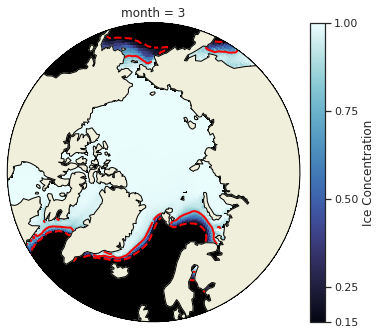

CPU times: user 362 ms, sys: 2.96 ms, total: 365 ms
Wall time: 367 ms


In [65]:
%%time
# datasel = cice_all_m.sel(month=3)
with sns.axes_style('ticks'):
    fig = plt.figure(figsize=(14,5))
    plt.rcParams['hatch.color'] = 'white'

    proj = ccrs.NorthPolarStereo()#central_longitude=179-360)
    lowlat = 55

    ax = plt.subplot(projection=proj)
    ax.set_extent([-180, 180, lowlat, 90], ccrs.PlateCarree())
    ax.coastlines(zorder=3)
    ax.set_boundary(circle, transform=ax.transAxes)


#     cmap = copy.copy(plt.cm.PuBu)
    cmap = copy.copy(cmocean.cm.ice)
    # cmap = copy.copy(cmocean.cm.ice)
    cmap.set_under('k')

    ## pcolormesh ##
    iceplot = datasel.aice_d.plot.pcolormesh(
        'TLON','TLAT',
    #     norm=mpl.colors.LogNorm(vmin=0.05,vmax=4),
        vmin=0.15,vmax=1,
        add_colorbar=False,
        cmap=cmap,ax=ax,transform=ccrs.PlateCarree())
    cbar = fig.colorbar(iceplot,label='Ice Concentration',
                        ticks=np.append([0.15],np.linspace(0.25,1,4)),pad=.01)
    # iceplot.colorbar.set_label('Significant Wave Height [$m$]')
    # cbar.ax.set_yticklabels(['0.1','1.0'])


    ## Wave height contour f ##
    # wwplot.hs.where(wwplot.longitude < 180).plot.contourf(
    #     'longitude','latitude',
    # #     levels=[0.1,0.8],
    #     norm=mpl.colors.LogNorm(vmin=0.11,vmax=4),
    #     add_colorbar=True,cmap='cividis',
    #     ax=ax,transform=ccrs.PlateCarree())
    # wwplot.hs.where(wwplot.longitude > 180).plot.contourf(
    #     'longitude','latitude',
    # #     levels=[0.1,0.8],
    #     norm=mpl.colors.LogNorm(vmin=0.0001,vmax=4),
    #     add_colorbar=True,cmap='cividis',
    #     ax=ax,transform=ccrs.PlateCarree())

    ## MIZ contour lines ##
    datasel.aice_d.where(datasel.TLON < 180).plot.contour(
        'TLON','TLAT',
        levels=[0.15,0.8],add_colorbar=False,
        colors='r',linestyles=['--','-'],linewidths=[2,2],
        ax=ax,transform=ccrs.PlateCarree())
    datasel.aice_d.where(datasel.TLON > 180).plot.contour(
        'TLON','TLAT',
        levels=[0.15,0.8],add_colorbar=False,
        colors='r',linestyles=['--','-'],linewidths=[2,2],
        ax=ax,transform=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND,zorder=2)
    ax.add_feature(cfeature.OCEAN,zorder=0,color='k')

    plt.tight_layout()
    plt.show()

In [56]:
cmocean.cm.ice